In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

## IDEA DEL EXPERIMENTO
+ Modelar el problema como un caso de detección de anomalias usando un autoencoder.
+ Se entreno una red neuronal (Autoencoder) con los datos de continua. La finalidad de esta red es reconstruir la entrada de 153 features teniendo una capa de contracción de 8 neuronas. 
+ Es de esperar que el modelo reconstruya mejor la clase para la cual fue entrenada (continua) y tenga errores de reconstrucción menores que cuando se quiera usar para casos BAJA+1 BAJA+2 (casos anormales) en donde se espere que el error de reconstrucción sea mayor. 


In [2]:
os.chdir( "C:\\Users\\vyago\\Desktop\\Maestría Ciencias de Datos\\07-DMEYF" )

dataset = pd.read_csv("./datasets/competencia2_2022.csv.gz", low_memory=False)


enero = dataset.loc[dataset["foto_mes"]==202101]
marzo = dataset.loc[dataset["foto_mes"]==202103]


In [3]:
enero=enero.fillna(0) # RELLENO CON 0 LOS NULOS, LO NECESITA LA RED
marzo = marzo.fillna(0)

In [4]:
marzo["clase_binaria"] = marzo["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0) #CLASE COMBINADA
enero["clase_binaria"] = enero["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0)
drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]
X_train = enero[enero.columns.drop( drop)]
y_train = enero["clase_binaria"]
X_test = marzo[marzo.columns.drop(drop)]
y_test = marzo["clase_binaria"]


In [5]:
# ESCALADO DE FEATURES
train_max = X_train.max()
train_min = X_train.min()


train_data = (X_train - train_min)/(train_max - train_min)
test_data = (X_test - train_min)/(train_max - train_min)


In [6]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [7]:
train_labels = y_train.values.astype(bool)
test_labels = y_test.values.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [8]:
normal_train_data.shape

TensorShape([159828, 152])

## Modelo

In [9]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64,activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(16, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64,activation="relu"),
      layers.Dense(152, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [10]:
autoencoder.compile(optimizer='adam', loss='mae')

In [11]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=500, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/500
313/313 [==============================] - 3s 3ms/step - loss: 0.0715 - val_loss: 0.0220
Epoch 2/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0209 - val_loss: 0.0198
Epoch 3/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0187 - val_loss: 0.0183
Epoch 4/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0175 - val_loss: 0.0156
Epoch 5/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 6/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 7/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 8/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 9/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0143
Epoch 10/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0142 - val_lo

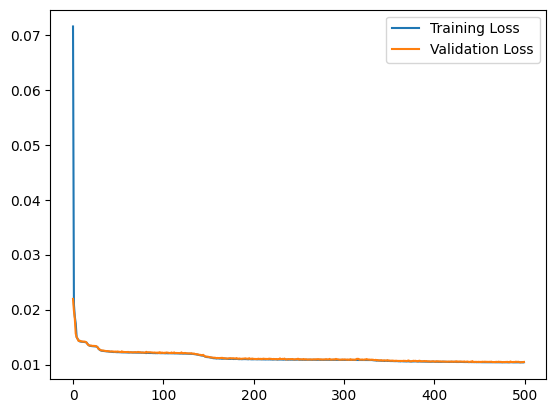

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

## Perdida de reconstrucción en ENERO (entrenamiento)

4995/4995 [==============================] - 8s 2ms/step


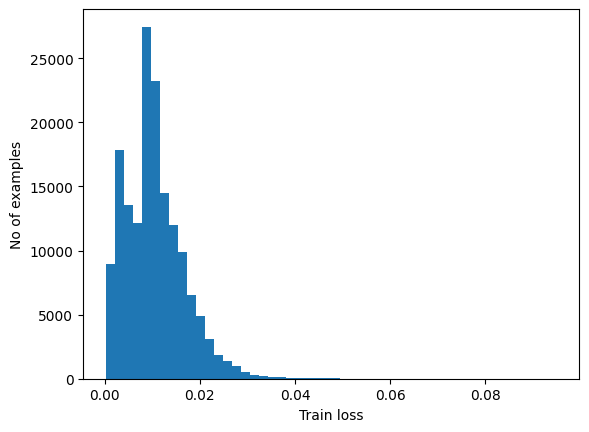

In [13]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

48/48 [==============================] - 0s 4ms/step


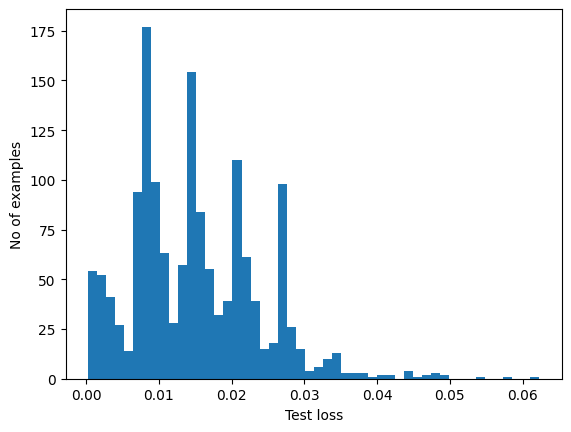

In [14]:
reconstructions = autoencoder.predict(anomalous_train_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_train_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [15]:
def ganancia (normal,anormal):
    gan = 78000*anormal-2000*normal
    return gan



def corte (normal,anormal):
    ganancia_max = -2000000
    thresold = None
    cantidad_envios= None
    for c in np.arange(0.01,0.08,0.0001):
        cant_normal = np.count_nonzero(normal > c)
        cant_anormal = np.count_nonzero( anormal > c)
        gan = ganancia (cant_normal,cant_anormal)
        if gan >ganancia_max:
            threshold = c
            ganancia_max = gan
            cantidad_envios = cant_normal+cant_anormal
    return threshold,ganancia_max,cantidad_envios

    

In [16]:
anormal = test_loss.numpy()
normal = train_loss.numpy()

c, ganancia, envios = corte(normal,anormal) # en base a entrenamiento saco mi mejor punto de corte que maximiza mi ganancia


In [17]:
envios

12230

In [18]:
ganancia

12340000

## Predicción contra marzo (TEST)

In [19]:
reconstruccion_marzo_continua =  autoencoder.predict(normal_test_data)
marzo_loss_continua =  tf.keras.losses.mae(reconstruccion_marzo_continua, normal_test_data)

5029/5029 [==============================] - 9s 2ms/step


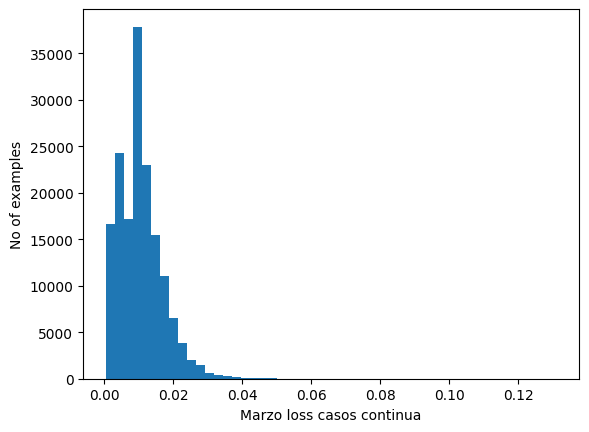

In [20]:
plt.hist(marzo_loss_continua[None, :], bins=50)
plt.xlabel("Marzo loss casos continua")
plt.ylabel("No of examples")
plt.show()

In [21]:
reconstruccion_marzo_abandona =  autoencoder.predict(anomalous_test_data)
marzo_loss_abandona =  tf.keras.losses.mae(reconstruccion_marzo_abandona, anomalous_test_data)

62/62 [==============================] - 0s 4ms/step


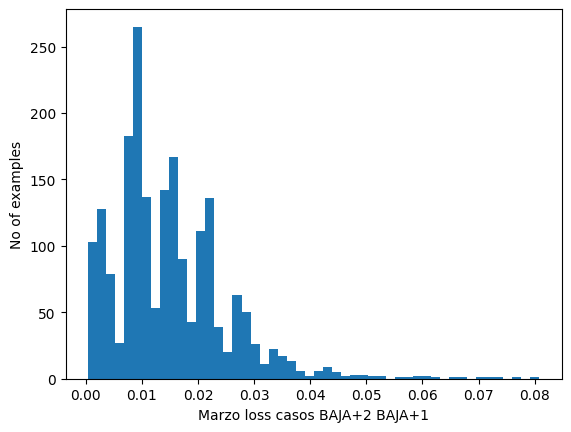

In [22]:
plt.hist(marzo_loss_abandona[None, :], bins=50)
plt.xlabel("Marzo loss casos BAJA+2 BAJA+1")
plt.ylabel("No of examples")
plt.show()

In [28]:
c

0.01999999999999994

In [23]:
#CALCULO DE GANANCIA PARA MARZO USANDO PUNTO DE CORTE OBTENIDO EN ENERO
marzo_loss_abandona = marzo_loss_abandona.numpy()
marzo_loss_continua = marzo_loss_continua.numpy()



In [24]:
cantidad_continua = np.count_nonzero(marzo_loss_continua > c)
cantidad_abandona = np.count_nonzero(marzo_loss_abandona > c)

In [25]:
cantidad_continua # cantidad de clientes que estimularia y hubieran continuado

12219

In [26]:
cantidad_abandona #cantidad de clientes que estimularia y se hubieran ido (sumando baja+1 y baja+2)

556

In [27]:
78000*cantidad_abandona-2000*cantidad_continua

18930000

## CONCLUSIÓN 

El modelo es exitoso y arroja ganancias positivas en la clasificación de clientes, se puede distinguir claramente dos distribuciones totalmente diferentes en los errores de reconstrucción en ambas clases. Pero como contraposición, no alcanza los valores de ganancias que ofrecen los algoritmos de boosting.